# Feature Engineering, Preprocessing, and Modeling

In [64]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import prince # factor analysis library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
import optuna
import warnings
import time

%matplotlib inline

In [21]:
# import data
bgg = pd.read_csv('Data/browse_cmf_credits_raw.csv', index_col=0)
pd.set_option('max_colwidth', 120)

In [22]:
# checking that the data types are correct
bgg.dtypes

avg_rating       float64
geek_rating      float64
num_voters         int64
title             object
full_game_url     object
rank               int64
game_id            int64
category          object
mechanic          object
family            object
age                int64
max_play_time      int64
max_players        int64
min_play_time      int64
min_players        int64
weight           float64
dtype: object

In [23]:
# checking for null values
bgg.isnull().sum()

avg_rating          0
geek_rating         0
num_voters          0
title               0
full_game_url       0
rank                0
game_id             0
category          211
mechanic         1567
family           4614
age                 0
max_play_time       0
max_players         0
min_play_time       0
min_players         0
weight              0
dtype: int64

In [24]:
# filling nulls in categorical labels with "None"
bgg.fillna('None', inplace=True)

# confirming categorical nulls are replaced
bgg[['category','mechanic','family']].isnull().sum()

category    0
mechanic    0
family      0
dtype: int64

The family label is sparse with 2,748 different families. Using this as a feature would increase dimensionality significantly, but also many of families are unique or specific to a game or set of games, so this will not generalize well to new data. However, as we saw in EDA, Kickstarter games have a statistically higher average Geek Rating, so I do want to create a column indicating if a game was or wasn't on Kickstarter.

In [25]:
# create new column named Kickstarter and drop family column
bgg['kickstarter'] = bgg['family'].str.contains('Kickstarter')
bgg.drop(columns=['family'], inplace=True)

In [26]:
# creating dummy columns for category label
cat_dummy = bgg.category.str.get_dummies(',').add_prefix('cat_').replace({1:True,0:False})

# creating dummy columns for mechanic label
# three mechanics have commas which need to be removed before creating dummies 
bgg['mechanic'] = bgg['mechanic'].str.replace('Deck, Bag, and Pool Building', 'Deck Bag and Pool Building')
bgg['mechanic'] = bgg['mechanic'].str.replace('I Cut, You Choose', 'I Cut You Choose')
bgg['mechanic'] = bgg['mechanic'].str.replace('Worker Placement, Different Worker Types', 'Worker Placement Different Worker Types')
mech_dummy = bgg.mechanic.str.get_dummies(',').add_prefix('mech_').replace({1:True,0:False})

# concatenating with original dataframe and dropping the category and mechanic columns
bgg = pd.concat([bgg, cat_dummy, mech_dummy], axis=1)
bgg.drop(columns=['category','mechanic'], inplace=True)

### Train-Test-Split, Imputing, Scaling and Dimensionality Reduction

The target variable will be Geek Rating, specifically if a game be in the top 1,000. Since its derived from average rating we will drop average rating. Number of voters correlates with Geek Rating, but in this context I want the model to predict the rating of a new game. Any value for number of voters for a new game would be arbitrary. Title, game url, rank, and game id are not relevant to the model and can be dropped.

In [27]:
# creating binary response column for top 1000 games
bgg['top_1000'] = bgg['rank'] <= 1000
bgg['top_1000'].replace({True:1,False:0}, inplace=True)

#### Train-Test-Split

In [28]:
# setting features, X and response variable, y
X = bgg.drop(columns=['avg_rating','geek_rating','num_voters','title','full_game_url','rank','game_id','top_1000'])
y = bgg.top_1000

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True)

#### Imputing

missing values are represented as 0 in this data set. I've chosen kNN to impute the missing values.

In [29]:
# subsetting numerical values to be imputed
X_train_transform = X_train[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]
X_test_transform = X_test[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]

# instantiating the imputer object
knn_imputer = KNNImputer(missing_values=0)

# fit to training data 
knn_imputer.fit(X_train_transform)

# transform training data 
X_train_transform = pd.DataFrame(knn_imputer.transform(X_train_transform),
                              columns=['age', 'max_play_time','max_players','min_play_time',
                                       'min_players','weight'])

# transform test data
X_test_transform = pd.DataFrame(knn_imputer.transform(X_test_transform),
                              columns=['age', 'max_play_time','max_players','min_play_time',
                                       'min_players','weight'])

# concatenate imputed columns back with categorical columns
X_train = pd.concat([X_train_transform, X_train.iloc[:,6:].reset_index()], axis=1)
X_test = pd.concat([X_test_transform, X_test.iloc[:,6:].reset_index()], axis=1)

#### Scaling and Dimensionality Reduction

The Prince library performs factor analysis of mixed data i.e. it simultaneously applies PCA and MCA all in one step. It also standardizes and scales the numerical variables. I first determine the number of components needed to maintain 90% of the explained variance then fit and transform the data.

In [30]:
# dimensionality reduction
# factor analysis of mixed data from https://github.com/MaxHalford/prince
famd = prince.FAMD(n_components=X_train.shape[1], n_iter=3, copy=True,
                   check_input=True, engine='sklearn', random_state=23)

famd.fit(X_train)
explained_variance = famd.explained_inertia_

# function to determine the number of components needed to reach desired explained variance
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    
    # for the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # add the explained variance to the total
        total_variance += explained_variance
        
        # add one to the number of components
        n_components += 1
        
        # break if we reach our goal level of explained variance
        if total_variance >= goal_var:
            break
            
    # Return the number of components
    return n_components

goal_var = 0.90
components = select_n_components(explained_variance,goal_var)
print(f'{components} components are needed to explain {goal_var}% of the variance')

125 components are needed to explain 0.9% of the variance


In [31]:
# creating factor analysis object with n_components necessary to keep 90% of the variance
famd = prince.FAMD(n_components=components, n_iter=3, copy=True,
                   check_input=True, engine='sklearn', random_state=23)

# fit and transform data
famd.fit(X_train)
X_train = famd.transform(X_train)
X_test = famd.transform(X_test)

### Modeling
Trying some out of the box models to get a baseline

In [173]:
# creating an empty dictionary to store model metrics
model_dict = {}

In [174]:
# initiating model
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

# metrics
logreg_y_pred_prob = logreg.predict_proba(X_test)[:,1]
logreg_fpr, logreg_tpr, logreg_roc_threshold = roc_curve(y_test, logreg_y_pred_prob)
logreg_roc_auc = roc_auc_score(y_test, logreg_y_pred_prob)
logreg_precision, logreg_recall, logreg_pr_threshold = precision_recall_curve(y_test, logreg_y_pred_prob)
logreg_f1 = f1_score(y_test, logreg_pred)
logreg_pr_auc = auc(logreg_recall, logreg_precision)

# adding results to dictionary
model_dict['Logistic Regression'] = {'fpr':logreg_fpr,'tpr':logreg_tpr, 'roc_auc':logreg_roc_auc,
                                   'precision':logreg_precision, 'recall':logreg_recall,
                                     'f1':logreg_f1, 'pr_auc':logreg_pr_auc}

In [175]:
# initiating model
rf = RandomForestClassifier(random_state=23, max_depth=5)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# metrics
rf_y_pred_prob = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_y_pred_prob)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_prob)
rf_precision, rf_recall, rf_pr_threshold = precision_recall_curve(y_test, rf_y_pred_prob)
rf_f1 = f1_score(y_test, rf_pred)
rf_pr_auc = auc(rf_recall, rf_precision)

# adding results to dictionary
model_dict['Random Forest'] = {'fpr':rf_fpr,'tpr':rf_tpr, 'roc_auc':rf_roc_auc,
                                   'precision':rf_precision, 'recall':rf_recall,
                                   'f1':rf_f1, 'pr_auc':rf_pr_auc}

In [176]:
# initiating model
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state = 23)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

# metrics
gb_y_pred_prob = gb.predict_proba(X_test)[:,1]
gb_fpr, gb_tpr, gb_threshold = roc_curve(y_test, gb_y_pred_prob)
gb_roc_auc = roc_auc_score(y_test, gb_y_pred_prob)
gb_precision, gb_recall, gb_pr_threshold = precision_recall_curve(y_test, gb_y_pred_prob)
gb_f1 = f1_score(y_test, gb_pred)
gb_pr_auc = auc(gb_recall, gb_precision)

# adding results to dictionary
model_dict['Gradient Boosting Classifier'] = {'fpr':gb_fpr,'tpr':gb_tpr, 'roc_auc':gb_roc_auc,
                                   'precision':gb_precision, 'recall':gb_recall,
                                   'f1':gb_f1, 'pr_auc':gb_pr_auc}

In [177]:
# initiating model
svc = SVC(class_weight='balanced', probability=True, random_state = 23)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

# metrics
svc_y_pred_prob = svc.predict_proba(X_test)[:,1]
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_y_pred_prob)
svc_roc_auc = roc_auc_score(y_test, svc_y_pred_prob)
svc_precision, svc_recall, svc_pr_threshold = precision_recall_curve(y_test, svc_y_pred_prob)
svc_f1 = f1_score(y_test, svc_pred)
svc_pr_auc = auc(svc_recall, svc_precision)

# adding results to dictionary
model_dict['SVC'] = {'fpr':svc_fpr,'tpr':svc_tpr, 'roc_auc':svc_roc_auc,
                                   'precision':svc_precision, 'recall':svc_recall,
                                   'f1':svc_f1, 'pr_auc':svc_pr_auc}

In [178]:
# initiating model - sqrt of n data points is a reccomeneded starting point
knn = KNeighborsClassifier(n_neighbors=round(np.sqrt(len(X_train))).astype(int), n_jobs=-1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# metrics
knn_y_pred_prob = knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_test, knn_y_pred_prob)
knn_roc_auc = roc_auc_score(y_test, knn_y_pred_prob)
knn_precision, knn_recall, knn_pr_threshold = precision_recall_curve(y_test, knn_y_pred_prob)
knn_f1 = f1_score(y_test, knn_pred)
knn_pr_auc = auc(knn_recall, knn_precision)

# adding results to dictionary
model_dict['kNN Classifier'] = {'fpr':knn_fpr,'tpr':knn_tpr, 'roc_auc':knn_roc_auc,
                                   'precision':knn_precision, 'recall':knn_recall,
                                   'f1':knn_f1, 'pr_auc':knn_pr_auc}

print(f'{round(np.sqrt(len(X_train)))} neighbors')

123.0 neighbors


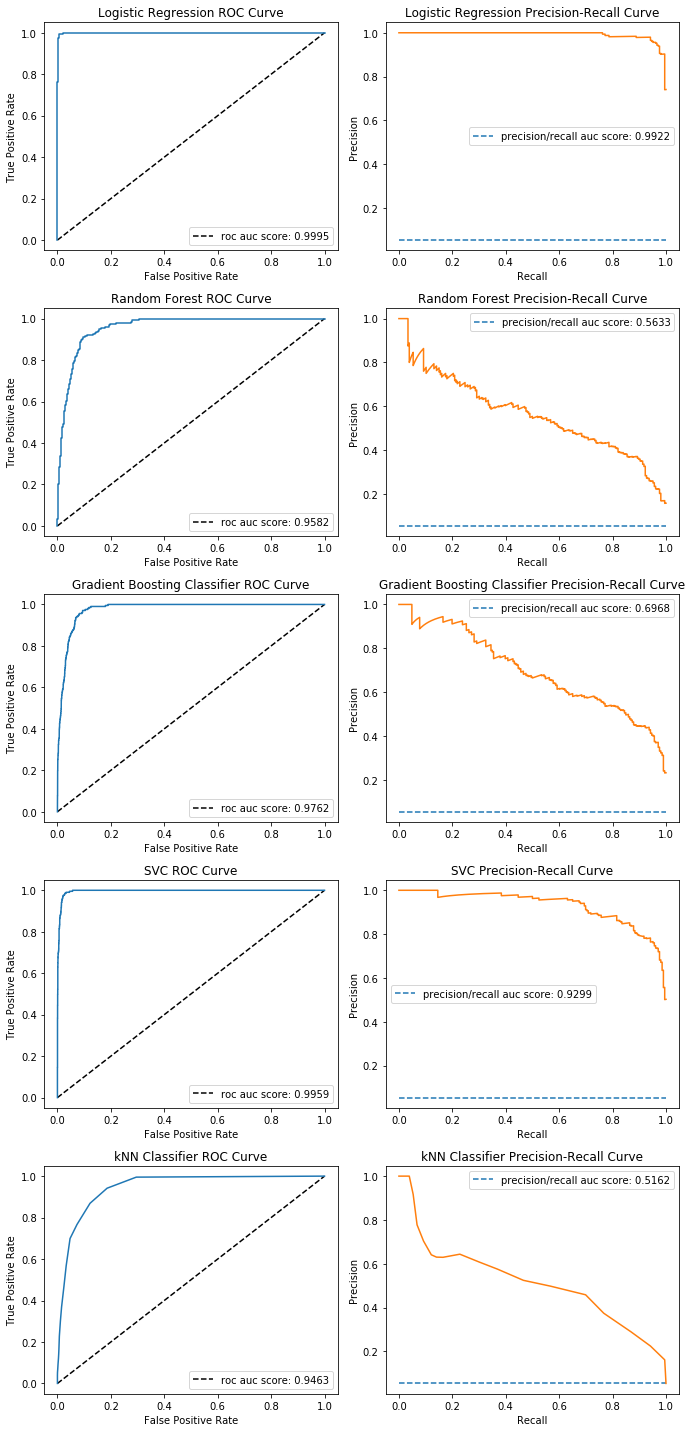

In [179]:
# create dataframe of the model dictionary
model_df=pd.DataFrame(model_dict)

no_skill = len(y_test[y_test==1]) / len(y_test) # horizontal line in precision/recall curve


_ = plt.subplots(figsize=(10,20))
n = 1
for col in model_df.columns:
    # plot ROC curve
    _ = plt.subplot(len(model_df.columns),2,n)
    _ = plt.plot([0,1],[0,1], 'k--')
    _ = plt.plot(model_df[col]['fpr'], model_df[col]['tpr'])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title(col + ' ROC Curve')
    _ = plt.legend(['roc auc score: ' + str(round(model_df[col]['roc_auc'],4))])
    n += 1
    
    # plot precision-recall curve
    _ = plt.subplot(5,2,n)
    _ = plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    _ = plt.plot(model_df[col]['recall'], model_df[col]['precision'])
    _ = plt.xlabel('Recall')
    _ = plt.ylabel('Precision')
    _ = plt.title(col + ' Precision-Recall Curve')
    _ = plt.legend(['precision/recall auc score: ' + str(round(model_df[col]['pr_auc'],4))])
    n += 1
    
plt.tight_layout()

In [193]:
model_df.loc[['roc_auc','pr_auc','f1']].T

,roc_auc,pr_auc,f1
Logistic Regression,0.999539,0.992179,0.814229
Random Forest,0.958202,0.56329,0
Gradient Boosting Classifier,0.976184,0.696761,0.376923
SVC,0.99594,0.929865,0.798419
kNN Classifier,0.946335,0.516242,0


I can certainly get better performance from these models, but, even without any tuning, logistic regression is suprisingly promising. I will move forward with tuning the logistic regression model.

### HyperParameter Tuning

First I'll do a GridSearch, but I also want to try out a Bayseian approach to compare.

#### GridSearch

In [19]:
# define the range of the parameters to optimize
param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
     'class_weight' : [None, 'balanced'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# initiate classifier
clf = LogisticRegression(random_state=23)
    
# initiate gridsearch
gs = GridSearchCV(clf, param_grid = param_grid, cv = 5, scoring='f1', verbose=True, n_jobs=-1)

# Fit on data and conduct search
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_logreg = gs.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 2746 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 73.2min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 85.8min finished


#### Bayseian Hyperparamter Tuning

In [23]:
# define an objective function to be maximized
def objective(trial):

    # suggest values for the hyperparameters using a trial object
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    c = trial.suggest_uniform('C', 0.01, 3.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    max_iter = trial.suggest_int('max_iter',50,1000)
    
    # object to maximize
    cv = cross_val_score(
        LogisticRegression(penalty=penalty,
                           C=c,
                           class_weight=class_weight,
                           solver=solver,
                           max_iter=max_iter,
                           random_state=23),
        X_train, y_train, cv=5, n_jobs=-1, scoring='f1')
    
    score = np.mean(cv)
    
    # if an invalid parameter combinations are tested this tells the sampler to avoid in the future
    if score == np.nan:
        raise optuna.structs.TrialPruned()
    return score

In [29]:
# create a study object and optimize the objective function
start_time = time.time()
with warnings.catch_warnings():
    # suppress warnings for invalid parameter combinations
    warnings.simplefilter("ignore")
    study01 = optuna.create_study(direction='maximize')
    study01.optimize(objective, n_trials=500)
end_time = time.time()
run_time = start_time - end_time
run_time

[I 2020-08-28 12:28:36,690] Trial 0 finished with value: 0.7684774192148632 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 1.3826001414173743, 'class_weight': 'balanced', 'max_iter': 750}. Best is trial 0 with value: 0.7684774192148632.
[I 2020-08-28 12:31:15,158] Trial 1 finished with value: 0.9198879836148197 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 2.949718704013123, 'class_weight': 'balanced', 'max_iter': 891}. Best is trial 1 with value: 0.9198879836148197.
[I 2020-08-28 12:31:28,216] Trial 2 finished with value: 0.8156588003247052 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 2.9260539520548288, 'class_weight': None, 'max_iter': 261}. Best is trial 1 with value: 0.9198879836148197.
[I 2020-08-28 12:31:47,271] Trial 3 finished with value: 0.7024215292754238 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 2.052041400155782, 'class_weight': None, 'max_iter': 185}. Best is trial 1 with value: 0.9198879836148197.
[I 2020-08-28 12:32:0

[W 2020-08-28 12:36:06,727] Trial 163 failed, because the objective function returned nan.
[W 2020-08-28 12:36:06,830] Trial 164 failed, because the objective function returned nan.
[W 2020-08-28 12:36:06,911] Trial 165 failed, because the objective function returned nan.
[W 2020-08-28 12:36:06,991] Trial 166 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,074] Trial 167 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,147] Trial 168 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,222] Trial 169 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,300] Trial 170 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,383] Trial 171 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,462] Trial 172 failed, because the objective function returned nan.
[W 2020-08-28 12:36:07,535] Trial 173 failed, because the objective function returned nan.

[W 2020-08-28 12:36:50,830] Trial 339 failed, because the objective function returned nan.
[W 2020-08-28 12:36:50,907] Trial 340 failed, because the objective function returned nan.
[W 2020-08-28 12:36:50,984] Trial 341 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,063] Trial 342 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,140] Trial 343 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,215] Trial 344 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,292] Trial 345 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,370] Trial 346 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,452] Trial 347 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,526] Trial 348 failed, because the objective function returned nan.
[W 2020-08-28 12:36:51,609] Trial 349 failed, because the objective function returned nan.

-544.7573208808899

#### Hyperparameter tuning results

GridSearchCV

In [20]:
print(best_logreg.best_params_)
print(best_logreg.best_score_)

{'C': 545.5594781168514, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9618931882220476


Bayseian 

In [30]:
print(study01.best_params)
print(study01.best_value)

{'penalty': 'none', 'solver': 'newton-cg', 'C': 2.447208829423313, 'class_weight': None, 'max_iter': 935}
0.9536496743567049


| Tuning Method | Number of Trials | Best F1 Score | Time (min) |
| --- | --- | --- | --- |
| GridSearchCV | 4,000 | 0.96189 | 86 |
| Bayseian | 500 | 0.95365 | 9  |

Gridsearch found a better model, but the Bayseian search was close with only a minimal run time. With more time I would expect Bayseain to match or even out perform gridsearch as its able to evaluate a larger parameter space.

In [53]:
# instatiating best model
best_logreg = LogisticRegression(C = 545.5594781168514,
                                 class_weight = None,
                                 penalty = 'l2', 
                                 solver = 'newton-cg',
                                random_state=23)

best_logreg.fit(X_train, y_train)

# metrics
best_logreg_pred = best_logreg.predict(X_test)
best_logreg_y_pred_prob = best_logreg.predict_proba(X_test)[:,1]
best_logreg_fpr, best_logreg_tpr, best_logreg_roc_threshold = roc_curve(y_test, best_logreg_y_pred_prob)
best_logreg_roc_auc = roc_auc_score(y_test, best_logreg_y_pred_prob)
best_logreg_precision, best_logreg_recall, best_logreg_pr_threshold = precision_recall_curve(y_test, best_logreg_y_pred_prob)
best_logreg_f1 = f1_score(y_test, best_logreg_pred)
best_logreg_pr_auc = auc(best_logreg_recall, best_logreg_precision)
best_logreg_accuracy = accuracy_score(y_test, best_logreg_pred)

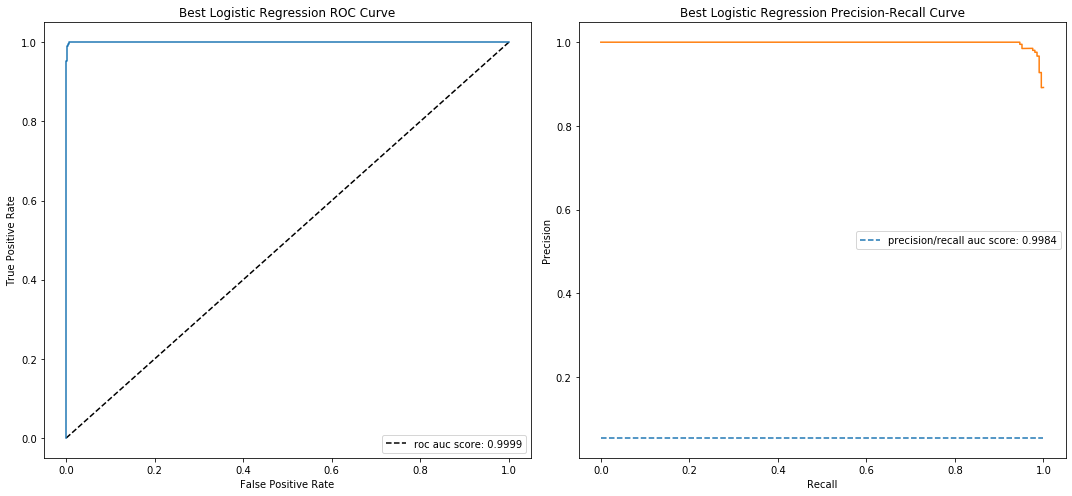

In [50]:
_ = plt.subplots(figsize=(15,7))
no_skill = len(y_test[y_test==1]) / len(y_test) # horizontal line in precision/recall curve

# plot best ROC curve
_ = plt.subplot(1,2,1)
_ = plt.plot([0,1],[0,1], 'k--')
_ = plt.plot(best_logreg_fpr, best_logreg_tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Best Logistic Regression ROC Curve')
_ = plt.legend([f'roc auc score: {round(best_logreg_roc_auc,4)}'])
    
# plot best precision-recall curve
_ = plt.subplot(1,2,2)
_ = plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
_ = plt.plot(best_logreg_recall, best_logreg_precision)
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Best Logistic Regression Precision-Recall Curve')
_ = plt.legend([f'precision/recall auc score: {round(best_logreg_pr_auc,4)}'])
    
plt.tight_layout()

In [54]:
print(classification_report(y_test, best_logreg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3598
           1       1.00      0.93      0.96       206

    accuracy                           1.00      3804
   macro avg       1.00      0.97      0.98      3804
weighted avg       1.00      1.00      1.00      3804



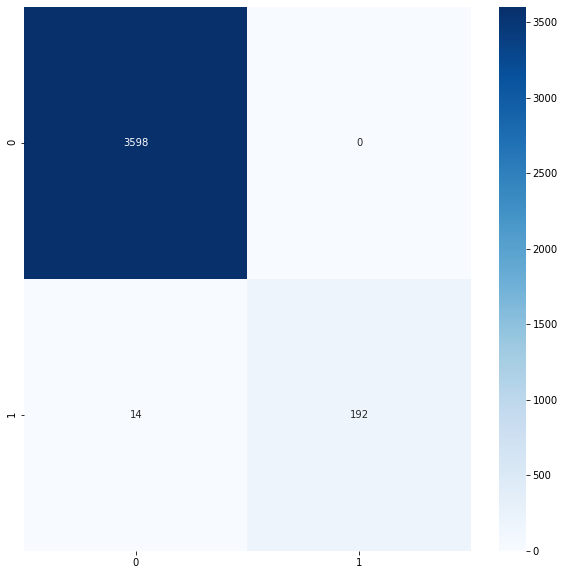

In [79]:
_ = plt.subplots(figsize=(10,10))
cmatrix = confusion_matrix(y_test, best_logreg_pred)
heatmap = sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='d')

# Conslusion

Use ROC/AUC score because - threshold independent (default is 0.5)
model outputs are a probaility so can adjust threshold to be more confident in positives

ROC AUC for figuring out which model is best 
then use gridsearch to determine threshold 

use classification report

Can we predict with labels only?

